In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning

from jas1101finalproject.fit import sigmar_2
from jas1101finalproject.fit import set_prior, set_likelihood
from jas1101finalproject.fit import DynamicNestedSampler

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

### Read GC

In [2]:
gc_name = "NGC_5139_oCen"

GC = GlobularCluster.from_name(gc_name)
GC.table_full[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm,member_prob_GMM,member_prob_DB
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
-0.4278635,0.4953495,-4.137772,0.2870662,0.4180685,0.3918257,-0.07201054,18.25189,1.236713,1,0.0,0.6545519855462207,4.147717942093753,1.0,0.0
-0.3602386,0.538408,-6.312083,-2.859151,1.261465,1.188454,0.04231181,19.9399,1.870787,0,0.0,0.6478078599353052,6.929439821492788,1.0,0.0
-0.465192,0.4700145,4.254552,-6.454558,0.3059969,0.2576483,-0.00953616,17.89003,1.777023,1,0.0,0.6612996499879991,7.730622982403681,1.0,0.0
-0.3684648,0.5347581,-7.493315,0.1467007,0.8672267,0.7991733,-0.06827305,19.053,1.192135,0,0.0,0.6494093734730428,7.494750882091111,1.0,0.0
-0.45197,0.4703616,-5.221955,1.478758,0.9482374,0.8935246,0.04315523,19.64893,1.940948,1,0.0,0.652316576253095,5.4272957579801195,1.0,0.0
-0.3733914,0.537619,-10.15176,-1.279566,1.526319,1.57452,0.1566563,20.28469,1.533587,0,0.0,0.6545649904745593,10.23208288893107,1.0,0.0
-0.5761971,0.3327234,-20.16073,-1.910327,3.301981,2.280316,0.2957819,20.50839,1.12841,0,0.0,0.6653630279448731,20.251034131121035,1.0,0.0
-0.4436906,0.488292,-6.007484,-0.6357325,1.060064,0.6891162,-0.03831959,19.4256,0.7997398,0,0.0,0.6597654324018196,6.041028043455207,1.0,0.0


In [3]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_5139_oCen,201.696,-47.479,5.2,234.3,0.2,17.6,40.0,-3.234,-6.719,0.039,0.039,-0.002,23635.0,25.21,0.475,0.522,0.011,7.456789993019785,"-3.265502995764545,-1.29923740052133,-3.8325542868613565"


### Make a new GC table using HDBSCAN membership

In [4]:
dmls: u.Quantity = u.dimensionless_unscaled  # shortcut

tab_DB = GC.table_full[GC.table_full['member_prob_DB']==1]
tab_DB['pm_e'] = np.hypot(tab_DB['pmx_e'], tab_DB['pmx_e'])

GC_DB = pd.DataFrame({'r':(tab_DB["r"] / GC.rc_ang).to_value(dmls),
                      'pm':(tab_DB["pm"] / GC.pmc_ang).to_value(dmls),
                      'pm_e':(tab_DB["pm_e"] / GC.pmc_ang).to_value(dmls)})

### Distibution of PM-R with Eugene's GMM membership

In [13]:
good = GC.pm_e < 2
good_DB = GC_DB.pm_e < 2

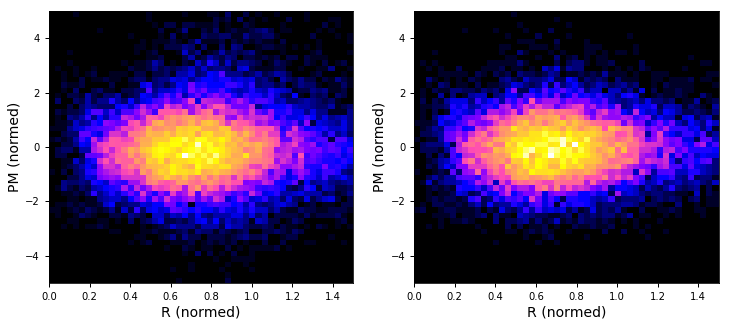

In [15]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

H, xb, yb, _ = ax1.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")
H, xb, yb, _ = ax2.hist2d(GC.r[good], GC.pm[good]-GC.pm[good].mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

### Distibution of PM-R with HDBSCAN membership

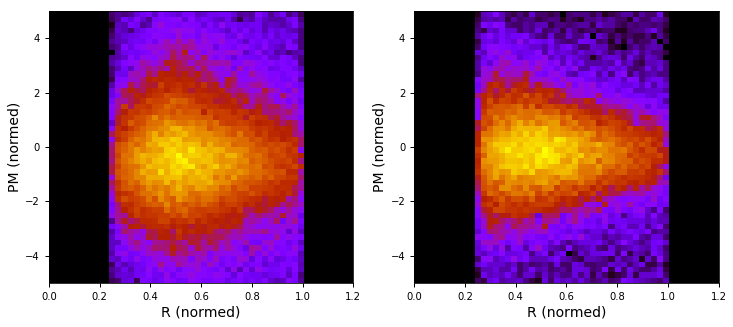

In [14]:
# display r-pm hist2d
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

H, xb, yb, _ = ax1.hist2d(GC_DB.r, GC_DB.pm-GC_DB.pm.mean(), bins=50, range=[[0,1.2],[-5,5]], norm=AsinhNorm(), cmap="gnuplot")
H, xb, yb, _ = ax2.hist2d(GC_DB.r[good_DB], GC_DB.pm[good_DB]-GC_DB.pm[good_DB].mean(), bins=50, range=[[0,1.2],[-5,5]], norm=AsinhNorm(), cmap="gnuplot")

for ax in ax1, ax2:
    ax.set_xlabel("R (normed)") # normalized
    ax.set_ylabel("PM (normed)") # normalized

### Distribution in Radius

(0, 1.2)

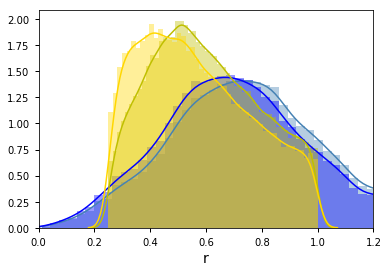

In [28]:
sns.distplot(GC.r, color='steelblue')
sns.distplot(GC.r[good], color='blue')
sns.distplot(GC_DB.r, color='y')
sns.distplot(GC_DB.r[good_DB], color='gold')
plt.xlim(0,1.2)

## Draw comparison of binned sigma profiles 
#### 1) with Eugene's GMM membership
#### 2) HDBSCAN membership
#### 3) without memeber selection.

In [26]:
# parameter of GC
M_gc = 4e6
r_scale = 38

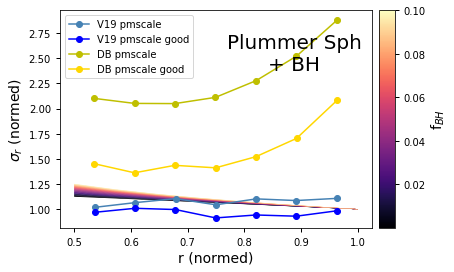

In [54]:
r_min, r_max = 0.5, 1
bins = np.linspace(r_min, r_max, 8)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.1, N_mod=25, fig=fig)

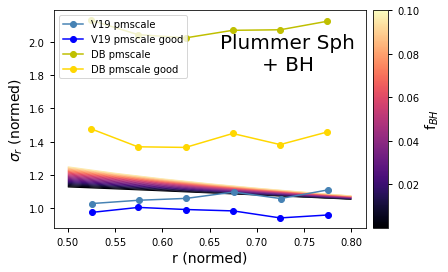

In [53]:
r_min, r_max = 0.5, 0.8
bins = np.linspace(r_min, r_max, 7)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.1, N_mod=25, fig=fig)

## Fitting sigma profile of a single cluster

In [60]:
r_min, r_max = 0.1, 1.5

use_DB = False
if use_DB:
    r, pm, pm_e = GC_DB.r, GC_DB.pm, GC_DB.pm_e
else:
    r, pm, pm_e = GC.r, GC.pm, GC.pm_e

# conditional cut
cond = (r>=r_min) & (r<=r_max) & (pm_e < 2)

# x and y, y_err for fitting
pm, pm_e = pm[cond], pm_e[cond]
r = r[cond]

PM = 14.362 +/- 0.964 


Text(0.5, 0, 'PM')

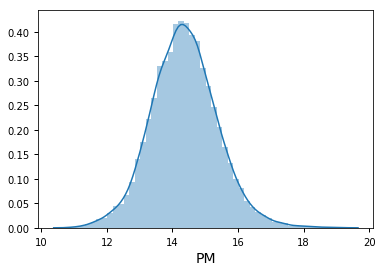

In [56]:
sns.distplot(pm)
print("PM = %.3f +/- %.3f "%(np.mean(pm), mad_std(pm)))
plt.xlabel("PM")

### Setup prior and likelihood

In [57]:
kind = 'scale-outlier'

prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=25, mu_ol_max=25)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

### Run Fitting

In [58]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=200, maxbatch=2)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 6


iter: 5473 | batch: 2 | bound: 113 | nc: 5 | ncall: 26187 | eff(%): 20.900 | loglstar: -16357.432 < -16353.212 < -16353.233 | logz: -16373.504 +/-  0.429 | stop:  3.407                              



Finish Fitting! Total time elapsed: 116 s

Pool Closed.


## Visualizing Fitting Result

## 1.  Fit in 0.5 < R < 0.8

#### DBSCAN membership

with measurement error and outlier

#### Eugene's membership

without measurement error / outlier

with measurement error and outlier

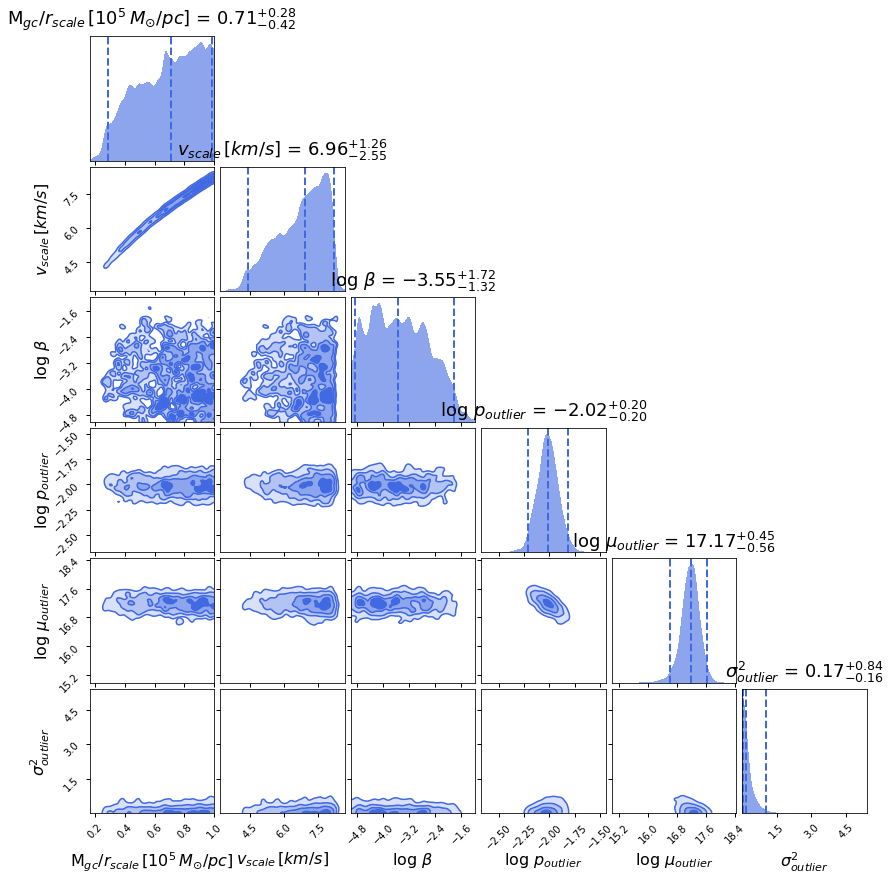

In [44]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12),labels=labels)

In [1]:
10**(-3.55+1.72)

0.01479108388168208

## 2. Fit in 0.5 < R < 1

#### Eugene's membership

with measurement error and outlier

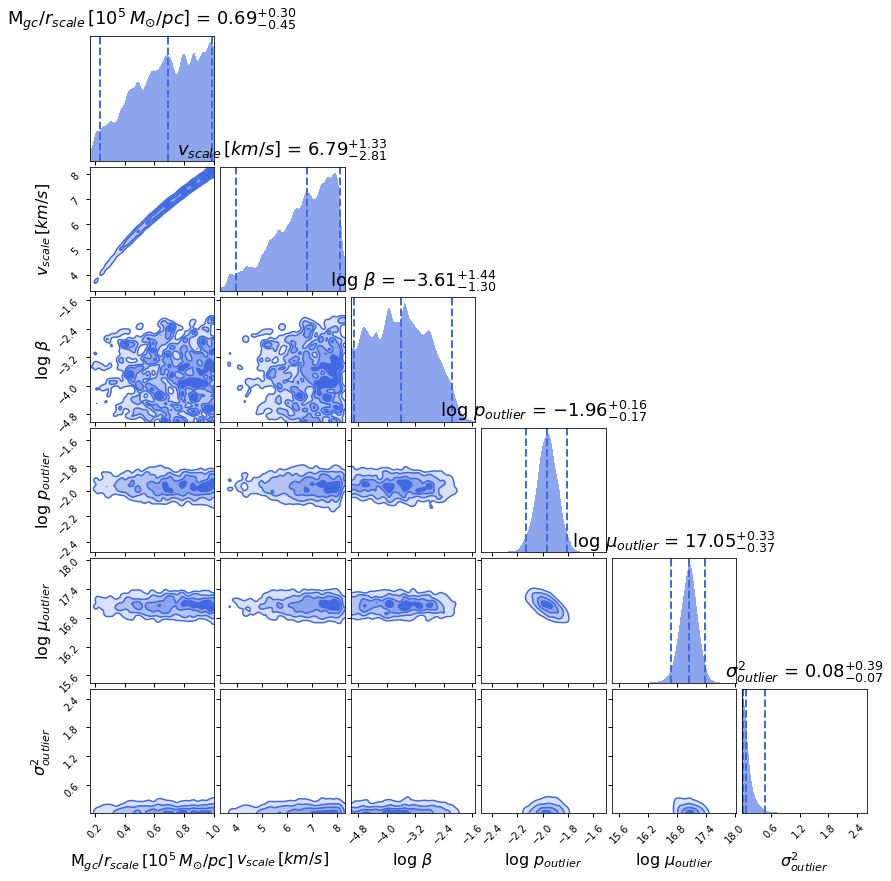

In [59]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12),labels=labels)

## 3. Fit R$_{min}$ and R$_{max}$

In [68]:
kind = 'scale-outlier-range'
prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=20, mu_ol_max=40)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

In [69]:
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=200, maxbatch=2)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 8


iter: 4951 | batch: 2 | bound: 56 | nc: 2 | ncall: 21534 | eff(%): 22.992 | loglstar: -2531.300 < -2528.409 < -2529.697 | logz: -2548.683 +/-  0.437 | stop:  4.118                                   



Finish Fitting! Total time elapsed: 81.7 s

Pool Closed.


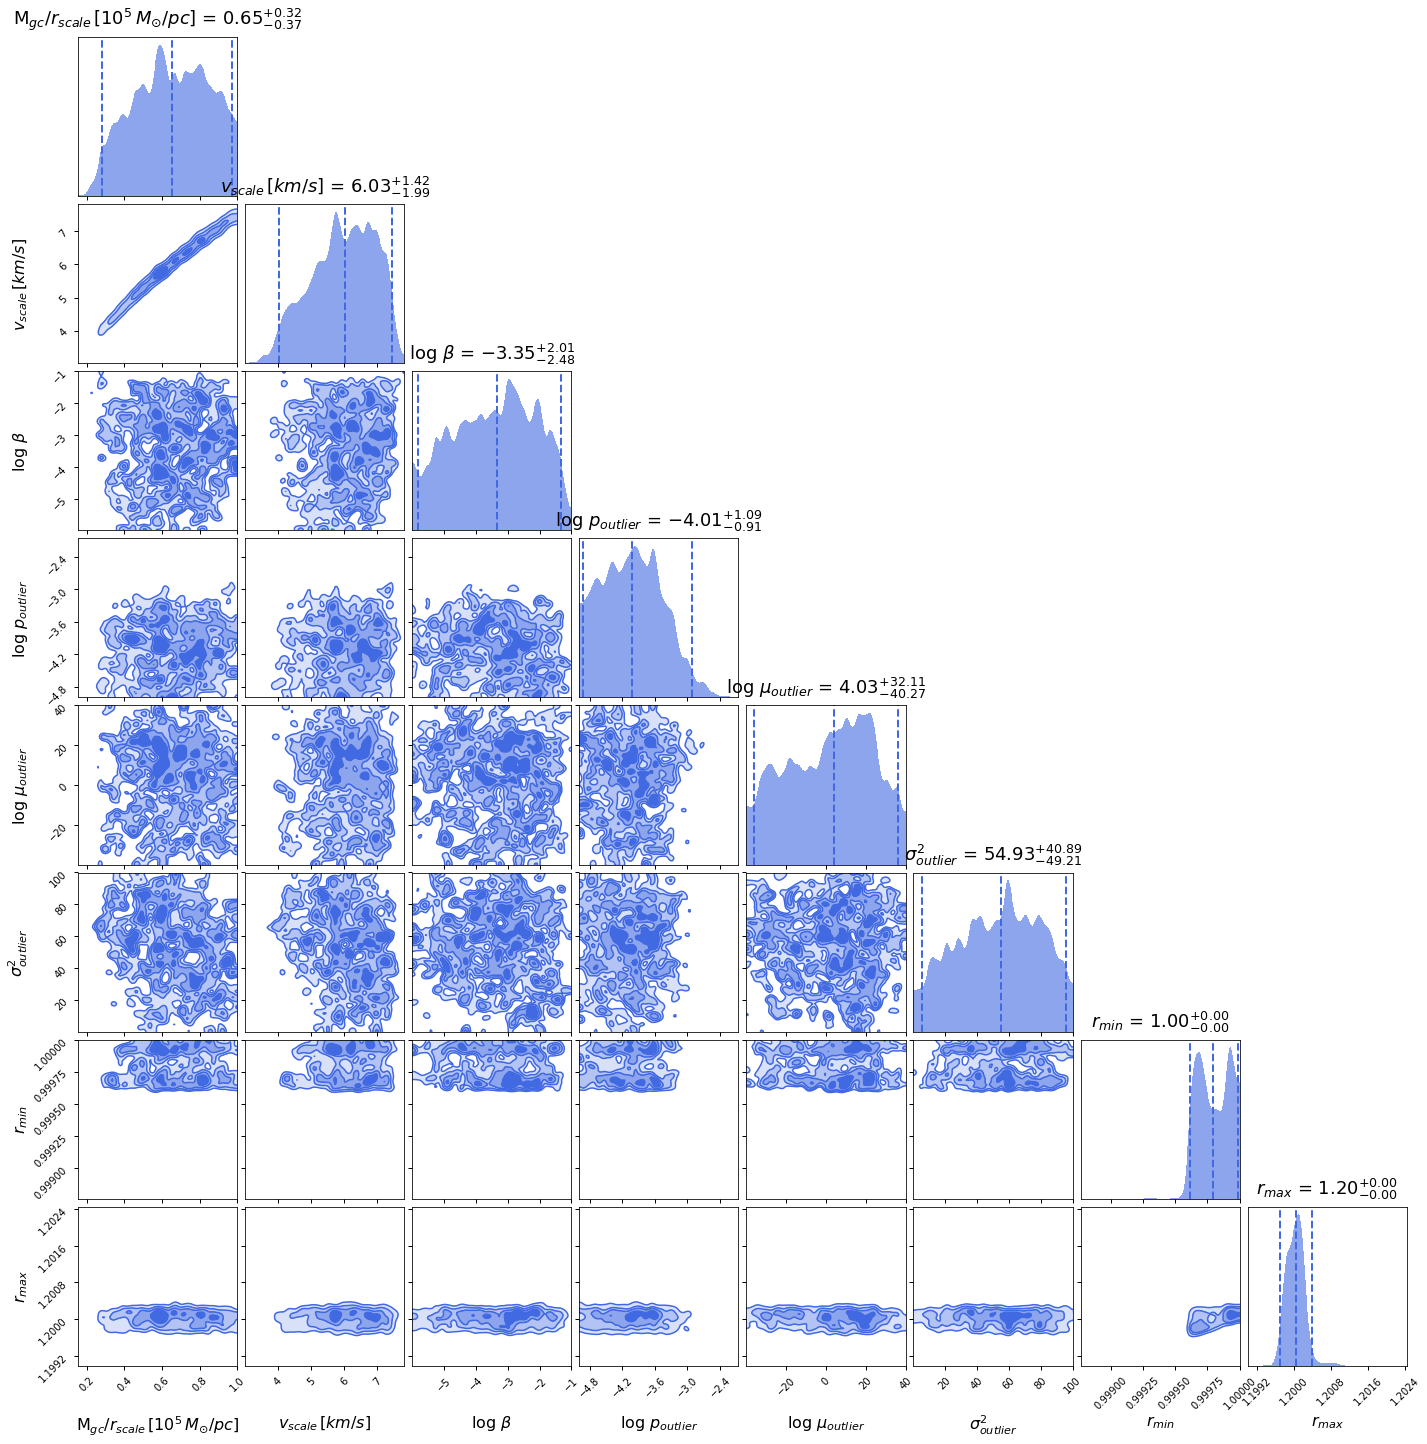

In [70]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$',
          '$r_{min}$', '$r_{max}$']
dsampler.cornerplot(figsize=(20,20), labels=labels)

Text(0.5, 0, 'log $\\beta$')

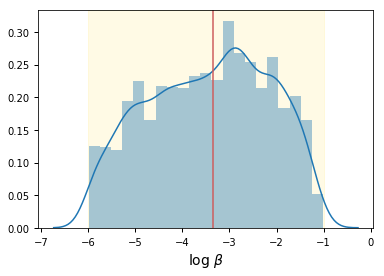

In [72]:
pmed, _, _, samples = dsampler.get_params(return_sample=True)
sns.distplot(samples[:,2])
plt.axvline(pmed[2], color='indianred')
plt.axvspan(-1, -6, color='gold',alpha=0.1,zorder=0)
plt.xlabel(r'log $\beta$')